In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('/kaggle/input/india-air-quality-data/data.csv', encoding='latin1', low_memory=False)
df.head()


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [3]:
for col in df.columns:
    print(col)


stn_code
sampling_date
state
location
agency
type
so2
no2
rspm
spm
location_monitoring_station
pm2_5
date


In [4]:
x = pd.to_numeric(df["no2"], errors='coerce')
x = x.dropna()


In [5]:
x = x[x >= 0]
x = x[x <= 500]
x = x.to_numpy()

len(x)


419503

In [6]:
a = 1.0
b = 0.9

z = x + a * np.sin(b * x)


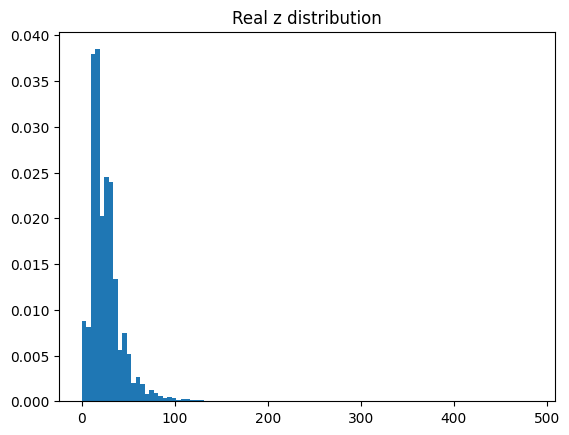

In [7]:
plt.hist(z, bins=100, density=True)
plt.title("Real z distribution")
plt.show()


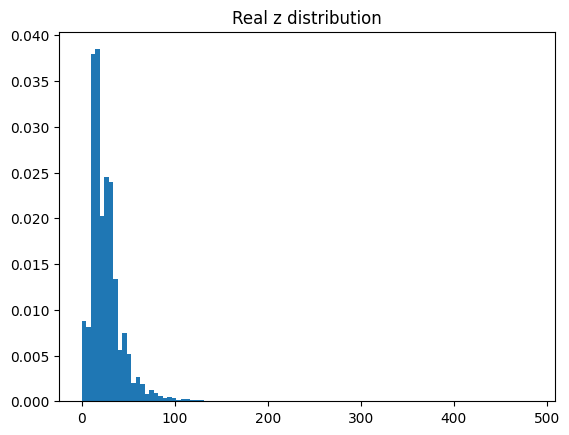

In [8]:
import matplotlib.pyplot as plt

plt.hist(z, bins=100, density=True)
plt.title("Real z distribution")
plt.show()


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim


In [14]:
z_mean = np.mean(z)
z_std = np.std(z)

z_norm = (z - z_mean) / z_std


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [17]:
z_tensor = torch.tensor(z_norm, dtype=torch.float32).view(-1,1).to(device)


In [27]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5,32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Tanh()
        )
    def forward(self,x):
        return self.net(x)

In [28]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,16),
            nn.LeakyReLU(0.2),
            nn.Linear(16,16),
            nn.LeakyReLU(0.2),
            nn.Linear(16,1)
        )
    def forward(self,x):
        return self.net(x)

In [29]:
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()

opt_G = optim.Adam(G.parameters(), lr=0.001)
opt_D = optim.Adam(D.parameters(), lr=0.001)


batch_size = 256
epochs = 100


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [31]:
G = G.to(device)
D = D.to(device)

z_tensor = z_tensor.to(device)


In [32]:
for epoch in range(epochs):

    perm = torch.randperm(len(z_tensor))
    z_shuffled = z_tensor[perm]

    for i in range(0, len(z_shuffled), batch_size):

        real = z_shuffled[i:i+batch_size]
        if len(real) == 0:
            continue

        real_labels = torch.ones((len(real),1), device=device)
        fake_labels = torch.zeros((len(real),1), device=device)

        # Train Discriminator
        noise = torch.randn(len(real),5, device=device)
        fake = G(noise)

        loss_D = criterion(D(real), real_labels) + criterion(D(fake.detach()), fake_labels)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Train Generator twice
        for _ in range(2):
            noise = torch.randn(len(real),5, device=device)
            fake = G(noise)

            loss_G = criterion(D(fake), real_labels)

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | D {loss_D.item():.3f} | G {loss_G.item():.3f}")


Epoch 0 | D 1.191 | G 0.819
Epoch 10 | D 1.323 | G 0.801
Epoch 20 | D 1.270 | G 0.689
Epoch 30 | D 1.285 | G 0.742
Epoch 40 | D 1.187 | G 0.649
Epoch 50 | D 1.213 | G 0.736
Epoch 60 | D 1.297 | G 0.650
Epoch 70 | D 1.308 | G 0.831
Epoch 80 | D 1.297 | G 0.810
Epoch 90 | D 1.247 | G 0.795


In [33]:
with torch.no_grad():
    noise = torch.randn(50000,5, device=device)
    z_fake = G(noise).cpu().numpy()


In [38]:
z_min = np.min(z)
z_max = np.max(z)


In [39]:
z_fake = (z_fake + 1)/2 * (z_max - z_min) + z_min
z_real = z


In [40]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(z_fake.flatten())
z_vals = np.linspace(min(z_real), max(z_real), 1000)


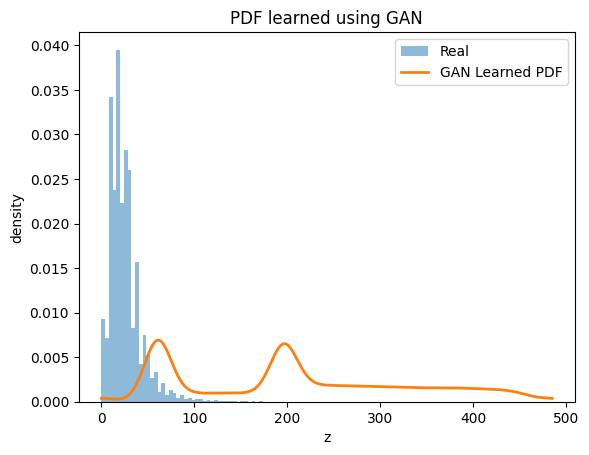

In [41]:
import matplotlib.pyplot as plt

plt.hist(z_real, bins=120, density=True, alpha=0.5, label="Real")
plt.plot(z_vals, kde(z_vals), linewidth=2, label="GAN Learned PDF")

plt.legend()
plt.xlabel("z")
plt.ylabel("density")
plt.title("PDF learned using GAN")
plt.show()
